# Calculate percentage cover using PostGIS

This notebook uses the same data as the [yo-pct-cover](yo-pct-cover.ipynb) notebook, but instead of using rasterio mask in conjunction with numpy it uses PostGIS to get the counts in each class for each local authority.  From these the percentage cover is then calculated using pandas.

The PostGIS query currently takes over 3 minutes to get the counts, while the function in the other notebook that includes the percentage calculation takes 5-6 seconds.

The datasets are:
Open local authority boundaries for England sourced from the Ordnance Survey: district_borough_unitary_region.shp https://www.ordnancesurvey.co.uk/business-and-government/products/boundary-line.html OS data © Crown copyright and database right 2018

The Water and Wetness dataset is from Copernicus: https://land.copernicus.eu/pan-european/high-resolution-layers/water-wetness

In [1]:
import psycopg2
import pandas as pd
import geopandas as gpd

import info # module containing postgis credentials

Set up the connection

In [2]:
conn = psycopg2.connect(database=info.pgdatabase, user=info.pgusername, host=info.pghost, password=info.pgpassword) 


Run the query and record how long it takes.  On the computer on which this notebook was developed, it took over three minutes.

Within the query the raster is being clipped to the geometry of each local authority and the results are grouped by local_authority.

The results are read into a pandas dataframe.

In [3]:
%%time
q = "SELECT unit_id, (ST_ValueCount(ST_Clip(rast,geom))).* FROM waw_2015_100m, local_authorities;"

df = pd.read_sql_query(q,con=conn)

Wall time: 3min 18s


Check the results.  Note that this query returns the count of each class rather than the percentage.

In [4]:
df.head(10)

,unit_id,value,count
0,18805,0.0,9366
1,18805,4.0,244
2,18805,3.0,38
3,18805,1.0,58
4,18805,2.0,12
5,9123,0.0,28111
6,9123,2.0,25
7,9123,1.0,134
8,9123,4.0,395
9,9123,3.0,7


The results of the query now need to be processed to calculate the percentage.

Rearrange the dataframe so that the id is used as the index and the classes become columns

In [5]:
wetness = df.pivot(index='unit_id', columns='value')['count']
wetness.reset_index(level=0, inplace=True)
wetness.fillna(value=0, inplace=True)

wetness.head()

value,unit_id,0.0,1.0,2.0,3.0,4.0,254.0,255.0
0,9,17799.0,36.0,1.0,0.0,3.0,0.0,0.0
1,18,26658.0,100.0,4.0,0.0,32.0,0.0,0.0
2,33,9865.0,5.0,0.0,0.0,1.0,0.0,0.0
3,72,10395.0,14.0,1.0,0.0,0.0,0.0,0.0
4,81,8542.0,18.0,2.0,0.0,4.0,0.0,0.0


Caculate the total count and use that to get the percentages.

In [6]:
wetness['total_count'] = wetness[0] + wetness[1] + wetness[2] + wetness[3] + wetness[4] + wetness[254]

wetness['Class0'] = (wetness[0] / wetness['total_count']) * 100
wetness['Class1'] = (wetness[1] / wetness['total_count']) * 100
wetness['Class2'] = (wetness[2] / wetness['total_count']) * 100
wetness['Class3'] = (wetness[3] / wetness['total_count']) * 100
wetness['Class4'] = (wetness[4] / wetness['total_count']) * 100
wetness['Class254'] = (wetness[254] / wetness['total_count']) * 100

wetness.head()

value,unit_id,0.0,1.0,2.0,3.0,4.0,254.0,255.0,total_count,Class0,Class1,Class2,Class3,Class4,Class254
0,9,17799.0,36.0,1.0,0.0,3.0,0.0,0.0,17839.0,99.775772,0.201805,0.005606,0.0,0.016817,0.0
1,18,26658.0,100.0,4.0,0.0,32.0,0.0,0.0,26794.0,99.492424,0.373218,0.014929,0.0,0.119430,0.0
2,33,9865.0,5.0,0.0,0.0,1.0,0.0,0.0,9871.0,99.939216,0.050653,0.000000,0.0,0.010131,0.0
3,72,10395.0,14.0,1.0,0.0,0.0,0.0,0.0,10410.0,99.855908,0.134486,0.009606,0.0,0.000000,0.0
4,81,8542.0,18.0,2.0,0.0,4.0,0.0,0.0,8566.0,99.719823,0.210133,0.023348,0.0,0.046696,0.0


Read in the local authority boundaries from PostGIS and join the two datasets on unit_id

In [7]:
qla = "SELECT name, unit_id, geom FROM local_authorities"

dfla = gpd.GeoDataFrame.from_postgis(qla, conn, geom_col='geom' )

# join the datasets
la_wetness = dfla.merge(wetness, on='unit_id')
la_wetness.head()

,name,unit_id,geom,0.0,1.0,2.0,3.0,4.0,254.0,255.0,total_count,Class0,Class1,Class2,Class3,Class4,Class254
0,Salford District (B),18805,(POLYGON ((3497080.004448751 3441040.135290764...,9366.0,58.0,12.0,38.0,244.0,0.0,0.0,9718.0,96.377856,0.596831,0.123482,0.391027,2.510805,0.0
1,Rotherham District (B),9123,(POLYGON ((3577869.395399302 3413457.489282725...,28111.0,134.0,25.0,7.0,395.0,0.0,0.0,28672.0,98.043387,0.467355,0.087193,0.024414,1.377651,0.0
2,Rochdale District (B),18825,"(POLYGON ((3529204.696776078 3457243.93698071,...",15331.0,156.0,13.0,0.0,326.0,0.0,0.0,15826.0,96.872236,0.985720,0.082143,0.000000,2.059901,0.0
3,Oldham District (B),18690,(POLYGON ((3530367.215723878 3455639.602156796...,13863.0,93.0,1.0,0.0,296.0,0.0,0.0,14253.0,97.263734,0.652494,0.007016,0.000000,2.076756,0.0
4,Solihull District (B),9,"(POLYGON ((3519877.33624913 3316004.374645095,...",17799.0,36.0,1.0,0.0,3.0,0.0,0.0,17839.0,99.775772,0.201805,0.005606,0.000000,0.016817,0.0


Now that we have the results we can close the connection.

In [8]:
# tidy up the connection
conn.close()

And display the results 

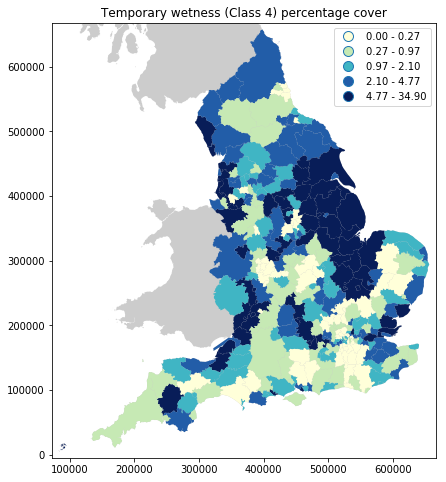

In [10]:
import matplotlib.pyplot as plt
from matplotlib import colors as c

backshp = "data/gb.shp"

# set up the plot and display
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# reproject the wetness index to National Grid
la_wetness.crs = {'init' :'epsg:3035'}
prjwet = la_wetness.to_crs({'init': 'epsg:27700'})

# set extent
bounds = prjwet.geometry.bounds
margin = 10000
plt.xlim([bounds.minx.min()-margin, bounds.maxx.max()+margin])
plt.ylim([bounds.miny.min()-margin, bounds.maxy.max()+margin]);

# read in the background shapefile
bkgrd = gpd.read_file(backshp)
bgcmap = c.ListedColormap(['#cccccc',])

# plot layers
bkgrd.plot(ax=ax, cmap=bgcmap)
prjwet.plot(ax=ax, column='Class4', legend = True, cmap='YlGnBu', scheme='quantiles')

plt.title("Temporary wetness (Class 4) percentage cover")

plt.show()